In [1]:
import RODFF.Mesh_maker as Mesh_maker
import RODFF.Functions as Functions
import RODFF.Calc_path as Calc_path
import RODFF.Flow_class as Flow_class

import pytest
from click.testing import CliRunner
import numpy as np
from scipy.spatial import Delaunay
from scipy.signal import argrelextrema

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import griddata


In [3]:
def slope(xs,ys,zs):
    tmp_A = []
    tmp_b = []
    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    fit = (A.T * A).I * A.T * b
    errors = b - A * fit
    residual = np.linalg.norm(errors)
    
    return fit[0], fit[1]

def curl(node, flow):
    nb = Mesh_maker.find_neighbors(node, flow.tria)
    nb = np.append(nb,node)
    DUDY = []
    DVDX = []
    xs = flow.nodes[nb][:,1]
    ys = flow.nodes[nb][:,0]
    for i in range(len(flow.t)):
        u = flow.u[i,nb]
        v = flow.v[i,nb]
        dudy = float(slope(xs,ys,u)[1])
        dvdx = float(slope(xs,ys,v)[0])
        DUDY.append(dudy)
        DVDX.append(dvdx)
    return np.mean(DUDY) - np.mean(DVDX)


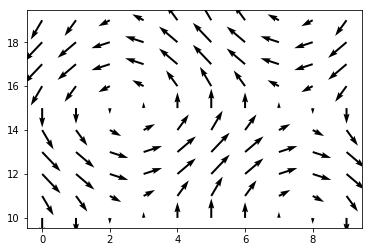

In [12]:
class flow_class():
    def __init__(self):
        self.t = np.arange(0,10)
        
        x = np.arange(0,10,1)
        y = np.arange(10,20,1)
        yy, xx = np.meshgrid(y,x)
        xx = xx.reshape(xx.size)
        yy = yy.reshape(yy.size)
        self.nodes = np.zeros((len(xx),2))
        self.nodes[:,1] = xx
        self.nodes[:,0] = yy
        self.tria = Delaunay(self.nodes)
        
        self.WD = np.ones((len(self.t), len(self.nodes)))*100
        self.u = [np.sin(np.pi*self.nodes[:,0]/5)]
        self.v = [-np.cos(np.pi*self.nodes[:,1]/5)]
        u = self.u
        v = self.v
        
        
        for i in range(len(self.t)-1):
            self.u = np.concatenate((self.u, u))
            self.v = np.concatenate((self.v, v))

flow = flow_class()

plt.quiver(flow.nodes[:, 1],
           flow.nodes[:, 0],
           flow.u[0,:],
           flow.v[0,:],
          )

In [14]:
CC = []
for node in range(len(flow.nodes)):
    C = curl(node, flow)
    CC.append(C)

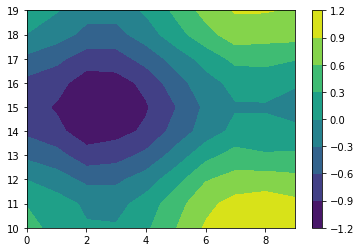

In [15]:
yy,xx = np.meshgrid(np.arange(10,20), np.arange(0,10))
CC_L = griddata(flow.nodes, CC, (yy,xx), method='linear')

plt.contourf(xx,yy,CC_L)
plt.colorbar()

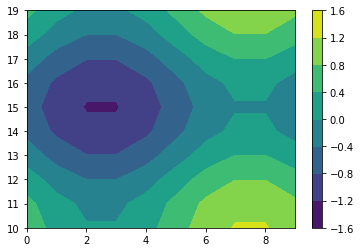

In [17]:
CCC = np.pi/5 * (np.cos(2*np.pi*flow.nodes[:,0]/10)-np.sin(2*np.pi*flow.nodes[:,1]/10))
#plt.plot(1/(1+CCC))

yy,xx = np.meshgrid(np.arange(10,20), np.arange(0,10))
CCC_L = griddata(flow.nodes, CCC, (yy,xx), method='linear')

plt.contourf(xx,yy,CCC_L)
plt.colorbar()

In [8]:
CCCC = CC - CCC

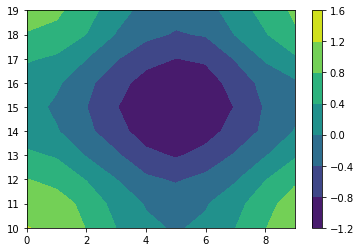

In [9]:
yy,xx = np.meshgrid(np.arange(10,20), np.arange(0,10))
CCCC_L = griddata(flow.nodes, CCCC, (yy,xx), method='linear')

plt.contourf(xx,yy,CCCC_L)
plt.colorbar()